In [1]:
library(ggplot2)
library(gridExtra)
library(scales)
library(dplyr)
library(latex2exp)
library(openxlsx)


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Choose color panel for three methods

In [2]:
# Update color panel to be colorblind friendly

# Not colorblind friendly:
# pal <- palette.colors(palette = "Set 1")
# show_col(pal)
# colors <- pal[1:3]

# https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
# Colorblind friendly, IBM color palette
colors <- c('#DC267F', '#648FFF', '#FFB000')
names(colors) <- c('scMultiMap','SCENT','Signac')

In [3]:
# save source data for figures
wb <- createWorkbook()

# Figure 1
Quantitative benchmarking on PBMC data with no batch effect.
* A: Type I error (simulation)
* B: PR-ROC curve (simulation)
* C: computing time

In [4]:
g_list <- list()
width_vec <- c(5,5,5)
height <- 5
names(width_vec) <- c('a','b','c')
uniform_bs <- 22

## Panel A: type I error

In [5]:
# load data generated from simulation/simulation_results_summary.ipynb
typeI_df <- readRDS('results/null_type_I_error.rds')
colnames(typeI_df)[2:3] <- c('method', 'typeI')
typeI_df$method <- factor(typeI_df$method,
                         levels = c('proposed','SCENT','Signac'),
                         labels = c('scMultiMap', 'SCENT', 'Signac'))
tmp <- ggplot(typeI_df) +
geom_boxplot(aes(x = method, y = typeI, color = method)) +
geom_hline(yintercept=0.05, linetype='dashed', color='black') +
labs(x = 'Method', y = 'Type 1 error', title = 'Type I error') +
scale_color_manual(values = colors) +
theme_classic(base_size=uniform_bs) +
theme(legend.position = 'none')
#ggsave('figures/PBMC/type_I_error_PBMC.pdf', tmp,
#      width = width_vec['A'], height = height)

g_list[['a']] <- tmp + labs(tag='a')

addWorksheet(wb, "Figure 1a")
writeData(wb, "Figure 1a", typeI_df)

## Panel b: PR-ROC

In [6]:
# load data generated from simulation/simulation_results_summary.ipynb
prroc_df <- readRDS('results/PRROC.rds')
prroc_df$method <- factor(prroc_df$method,
                         levels = c('proposed','SCENT','Signac'),
                         labels = c('scMultiMap', 'SCENT', 'Signac'))
tmp <- ggplot(prroc_df, aes(x = FDR, y = power, color = method)) +
geom_point() +
geom_line() +
labs(x = 'False Discovery Rate', y = 'Recall', title = 'Precision-recall curve') +
scale_color_manual(values = colors) +
theme_classic(base_size = uniform_bs) +
theme(legend.position = 'none')

#ggsave('figures/PBMC/precision_recall_PBMC.pdf', tmp,
#      width = width_vec['B'], height = height)
g_list[['b']] <- tmp + labs(tag = 'b')

addWorksheet(wb, "Figure 1b")
writeData(wb, "Figure 1b", prroc_df)

## Panel c: computing time

In [7]:
output_dir <- 'results/CD14 Mono'#sprintf('../../analysis/real_data/output/%s/%s', study, ct)
study <- 'PBMC_3k'
ct <- 'CD14 Mono'
suffix <- '_i_rep_1'

time_df <- data.frame(method = c('proposed', 'SCENT', 'Signac'), elapsed_time = numeric(3))
time_df$elapsed_time <- c(readRDS(sprintf('%s_scMultiMap_computing_time%s.rds', output_dir, suffix)) %>% as.numeric(units="hours"),
                          readRDS(sprintf('%s_SCENT_100%%_computing_time%s.rds', output_dir, suffix)) %>% as.numeric(units="hours"),
                          readRDS(sprintf('%s_Signac_computing_time%s.rds', output_dir, suffix)) %>% as.numeric(units="hours"))

time_df

# for writing
c(readRDS(sprintf('%s_scMultiMap_computing_time%s.rds', output_dir, suffix)) %>% as.numeric(units="secs"),
  readRDS(sprintf('%s_Signac_computing_time%s.rds', output_dir, suffix)) %>% as.numeric(units="hours"),
 readRDS(sprintf('%s_SCENT_100%%_computing_time%s.rds', output_dir, suffix)) %>% as.numeric(units="days"))

method,elapsed_time
<chr>,<dbl>
proposed,0.002320745
SCENT,35.284495272
Signac,1.456718038


[1] 8.354683 1.456718 1.470187

In [8]:
# https://stackoverflow.com/questions/12514612/how-to-annotate-ggplot-with-latex
# use latex for 10^x

tmp  <- ggplot(time_df) +
geom_bar(aes(x = method , y = log10(elapsed_time+1.01), fill = method), stat = 'identity') +
labs(title = 'Computing time', y = 'Elapsed time (hours)', x = 'Method') +
scale_fill_manual(values = colors) +
theme_classic(base_size = uniform_bs) +
theme(legend.position = 'none') + 
scale_y_continuous(breaks=c(0, 0.5,1,1.5),
        labels=c(TeX("$10^0$"), TeX("$10^{0.5}$"), TeX("$10^1$"), TeX("$10^{1.5}$")))

g_list[['c']]  <- tmp + labs(tag = 'c')

addWorksheet(wb, "Figure 1c")
writeData(wb, "Figure 1c", time_df)

Warning message:
“Removed 40 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 40 rows containing missing values (`geom_line()`).”


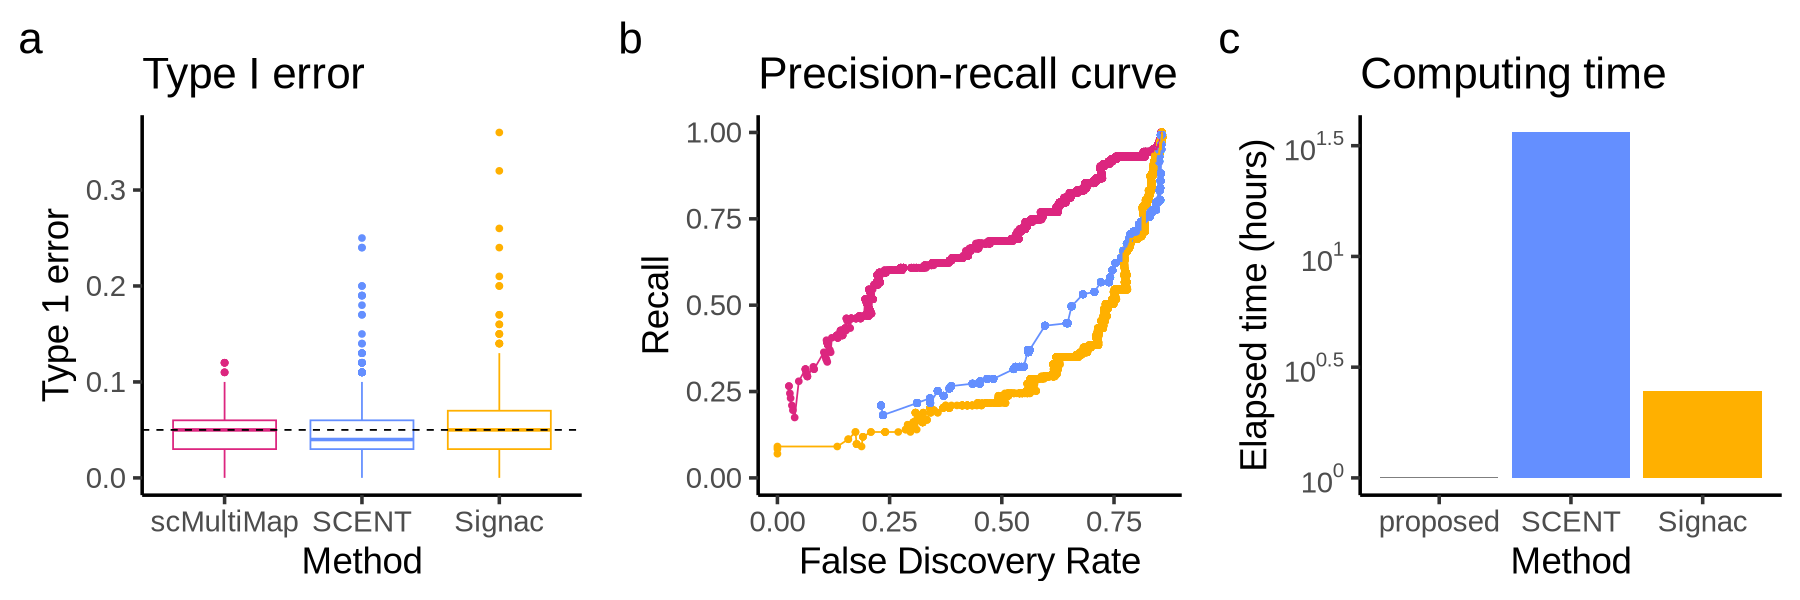

In [9]:
options(repr.plot.width = sum(width_vec), repr.plot.height = height)
g <- grid.arrange(grobs = g_list,
            widths = width_vec,
            heights = height)
ggsave('figures/figure_1.pdf', g,
      width = sum(width_vec), height = height)

# Figure 2

## Panel a

In [10]:
# load data generated from real_data_analysis/reproducibility_PBMC.ipynb
repro_df <- readRDS('results/PBMC_reproducibility.rds')

tmp <- ggplot(repro_df, aes(x = as.factor(p_cutoff), y = counts1, group = method, color = method)) +
geom_line() +
geom_point(aes(size = -log_p_val)) +
labs(y = '#reproduced pairs', x = 'Cutoff for adjusted p values', size = '-log p',
     tag = ''
    # , title = 'Reproduciblity across datasets'
    ) +
scale_size_continuous(limits = c(100,950), breaks = c(100,500,900)) +
facet_wrap(~replicate, scales = 'free', ncol = 1) +
scale_color_manual(values = colors) +
#geom_errorbar( aes(ymin = log(fe_conf_l), ymax = log(fe_conf_u)),width = 20, alpha = 0.6) +
theme_classic(base_size = uniform_bs) +
theme(legend.position = "bottom",
     strip.text.x = element_text(size = 22)) +
guides(color="none")
ggsave('figures/Fig_2a_reproducibility_PBMC.pdf', tmp,
      width = 5, height = 10)

addWorksheet(wb, "Figure 2a")
writeData(wb, "Figure 2a", repro_df)

## Panel b

In [11]:
options(repr.plot.width = 5, repr.plot.height = 5)
num_inc <- numeric(3)
fig2b_list <- list()

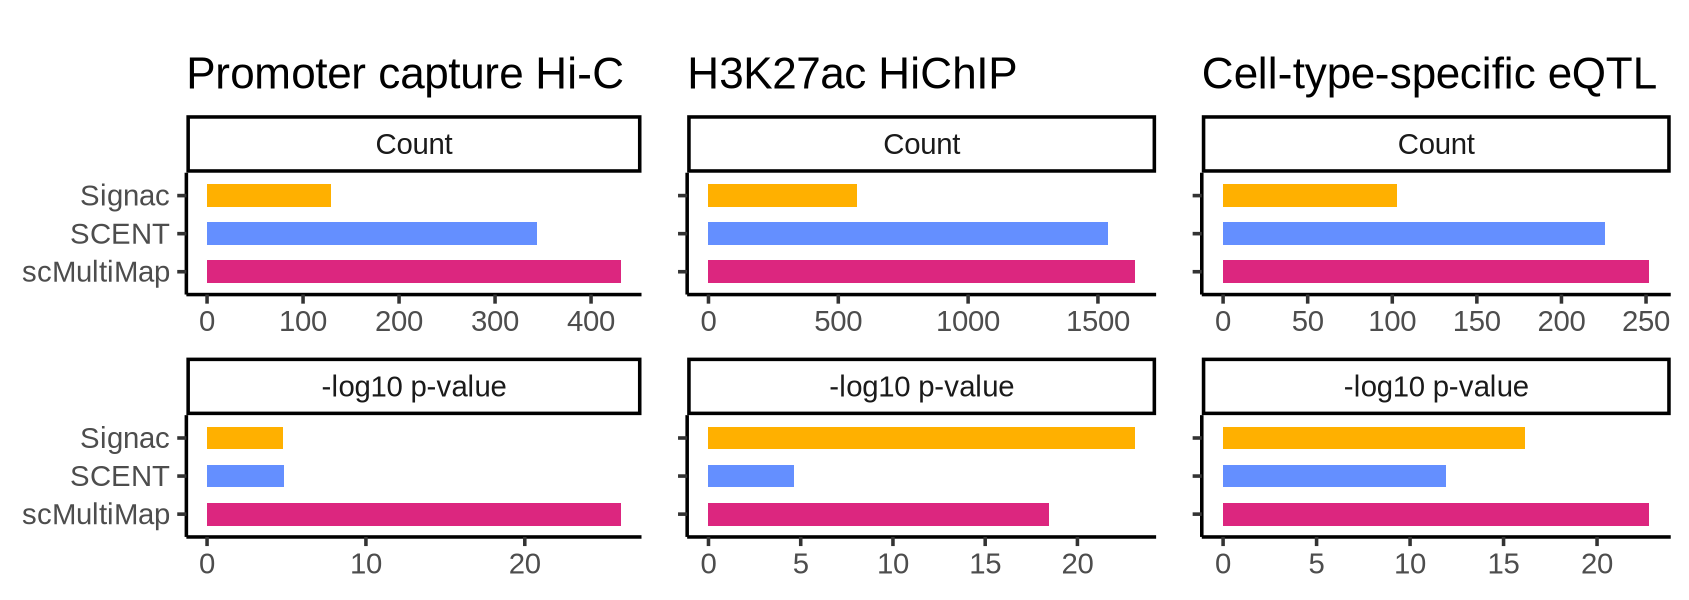

In [12]:
# load data generated from real_data_analysis/validation_PBMC.ipynb
output_dir <- 'results/PBMC_'

########
# PCHiC
########

hic_df <- readRDS(sprintf('%sPCHiC.rds', output_dir))

cd14_hic_df <- hic_df[hic_df$ct == 'CD14 Mono',]
long_hic_df <- data.frame(method = rep(cd14_hic_df$method,2),
                            values = c(cd14_hic_df$n_overlap, -log(cd14_hic_df$pval)),
                            stats = rep(c('Count', '-log10 p-value'), each = 3))
long_hic_df$method <- factor(long_hic_df$method,
                                levels = c('scMultiMap','SCENT','Signac'),
                         labels = c('scMultiMap', 'SCENT', 'Signac'))
long_hic_df$stats <- factor(long_hic_df$stats, levels = c('Count', '-log10 p-value'),
                             labels = c('Count', '-log10 p-value'))

fig2b_list[['PCHiC']] <- ggplot(long_hic_df) +
geom_bar(aes(y = method, x = values, fill = method), stat = 'identity', width = 0.6) +
scale_fill_manual(values = colors) +
labs(title = 'Promoter capture Hi-C', tag = '') +
facet_wrap(~stats, nrow = 2, scales = 'free') +
theme_classic(base_size = uniform_bs) +
theme(legend.position = 'none', axis.title.x=element_blank(), axis.title.y=element_blank()) 

########
# HiChIP
########

hichip_df <- readRDS(sprintf('%sHiChIP.rds', output_dir))

cd14_hichip_df <- hichip_df[hichip_df$ct == 'CD14 Mono',]
long_hichip_df <- data.frame(method = rep(cd14_hichip_df$method,2),
                            values = c(cd14_hichip_df$n_overlap, -log10(cd14_hichip_df$pval)),
                            stats = rep(c('Count', '-log10 p-value'), each = 3))
long_hichip_df$method <- factor(long_hichip_df$method,
                                 levels = c('scMultiMap','SCENT','Signac'),
                         labels = c('scMultiMap', 'SCENT', 'Signac'))
long_hichip_df$stats <- factor(long_hichip_df$stats, levels = c('Count', '-log10 p-value'),
                             labels = c('Count', '-log10 p-value'))

fig2b_list[['HiChIP']] <- ggplot(long_hichip_df) +
geom_bar(aes(y = method, x = values, fill = method), stat = 'identity', width = 0.6) +
scale_fill_manual(values = colors) +
labs(title = 'H3K27ac HiChIP', tag = '') +
facet_wrap(~stats, nrow = 2, scales = 'free') +
theme_classic(base_size = uniform_bs) +
theme(legend.position = 'none', axis.title.x=element_blank(), axis.title.y=element_blank(),
     axis.text.y = element_blank()) 

#######
# eQTL
#######
eqtl_df <- readRDS(sprintf('%seQTL.rds', output_dir))
long_eqtl_df <- data.frame(method = rep(eqtl_df$method,2),
                                values = c(eqtl_df$n_overlap, -log10(eqtl_df$pval)),
                            stats = rep(c('Count', '-log10 p-value'), each = 3))
long_eqtl_df$stats <- factor(long_eqtl_df$stats, levels = c('Count', '-log10 p-value'),
                             labels = c('Count', '-log10 p-value'))
long_eqtl_df$method <- factor(long_eqtl_df$method,
                                levels = c('scMultiMap','SCENT','Signac'),
                         labels = c('scMultiMap', 'SCENT', 'Signac'))

fig2b_list[['eQTL']] <- ggplot(long_eqtl_df) +
geom_bar(aes(y = method, x = values, fill = method), stat = 'identity', width = 0.6) +
scale_fill_manual(values = colors) +
labs(title = 'Cell-type-specific eQTL', tag = '') +
facet_wrap(~stats, nrow = 2, scales = 'free') +
theme_classic(base_size = uniform_bs) +
theme(legend.position = 'none', axis.title.x=element_blank(), axis.title.y=element_blank(),
     axis.text.y = element_blank()) 

width_vec <- c(5,3.9,3.9) * 1.1
height <- 5
options(repr.plot.width = sum(width_vec), repr.plot.height = height)
g <- grid.arrange(grobs = fig2b_list,
            widths = width_vec,
            heights = height)
ggsave('figures/Fig_2b_orthogonal_consistency_PBMC.pdf',
       g,
      width = sum(width_vec),
      height = height)

In [13]:
full_df <- 
rbind(cbind(long_hic_df, type='PCHiC'),
      cbind(long_hichip_df, type='HiChIP'),
      cbind(long_eqtl_df, type='eQTL'))

addWorksheet(wb, "Figure 2b")
writeData(wb, "Figure 2b", full_df)

## Panel c
Generated in real_data_analysis/trio_PBMC.ipynb

# Figure 3

In [14]:
width_vec <- c(5,5,11,5)
height <- 5
names(width_vec) <- c('a','b','c','d')
g_3_list <- list()

## Panel a

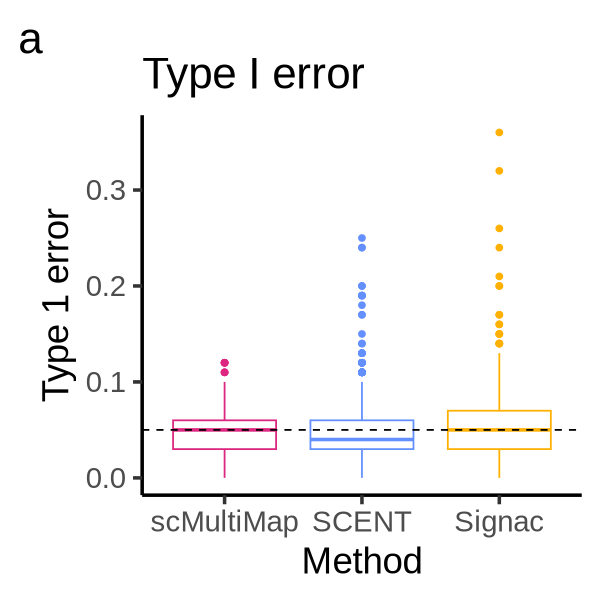

In [15]:
options(repr.plot.width = height, repr.plot.height = height)

# load data generated from simulation/simulation_results_summary.ipynb
typeI_df <- readRDS('results/null_type_I_error_batch_effect.rds')
colnames(typeI_df)[2:3] <- c('method', 'typeI')
typeI_df$method <- factor(typeI_df$method,
                         levels = c('proposed','SCENT','Signac'),
                         labels = c('scMultiMap', 'SCENT', 'Signac'))
tmp <- ggplot(typeI_df) +
geom_boxplot(aes(x = method, y = typeI, color = method)) +
geom_hline(yintercept=0.05, linetype='dashed', color='black') +
labs(x = 'Method', y = 'Type 1 error', title = 'Type I error') +
scale_color_manual(values = colors) +
theme_classic(base_size=uniform_bs) +
theme(legend.position = 'none')
#ggsave('figures/brain/type_I_error_brain.pdf', tmp,
#      width = width_vec['A'], height = height)

g_3_list[['a']] <- tmp + labs(tag='a')
g_3_list[['a']] 

addWorksheet(wb, "Figure 3a")
writeData(wb, "Figure 3a", typeI_df)

## Panel b: power

Warning message:
“Removed 40 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 40 rows containing missing values (`geom_line()`).”


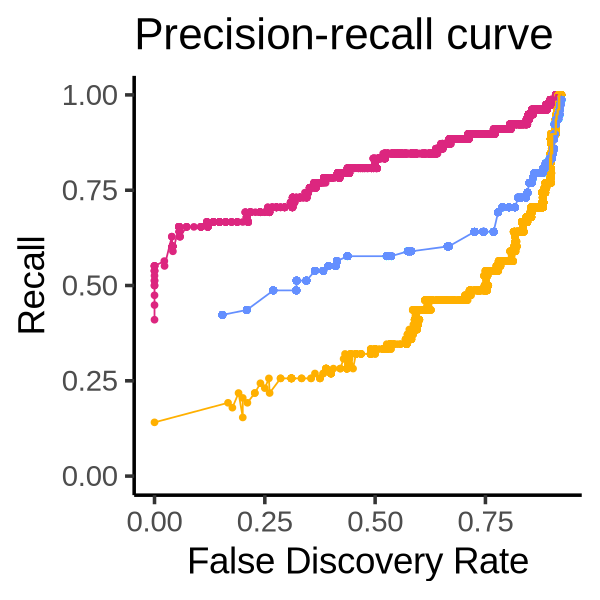

In [16]:
# load data generated from simulation/simulation_results_summary.ipynb
prroc_df <- readRDS('results/PRROC_batch_effect_SCENT_adjusted.rds')[['brain_CG']]
prroc_df$method <- factor(prroc_df$method,
                         levels = c('proposed','SCENT','Signac'),
                         labels = c('scMultiMap', 'SCENT', 'Signac'))
tmp <- ggplot(prroc_df, aes(x = FDR, y = power, color = method)) +
geom_point() +
geom_line() +
labs(x = 'False Discovery Rate', y = 'Recall', title = 'Precision-recall curve') +
scale_color_manual(values = colors) +
theme_classic(base_size = uniform_bs) +
theme(legend.position = 'none')

tmp
#ggsave('figures/brain/precision_recall_brain.pdf', tmp,
#      width = width_vec['B'], height = height)
g_3_list[['b']] <- tmp + labs(tag = 'b')

addWorksheet(wb, "Figure 3b")
writeData(wb, "Figure 3b", prroc_df)

## Panel c:consistency

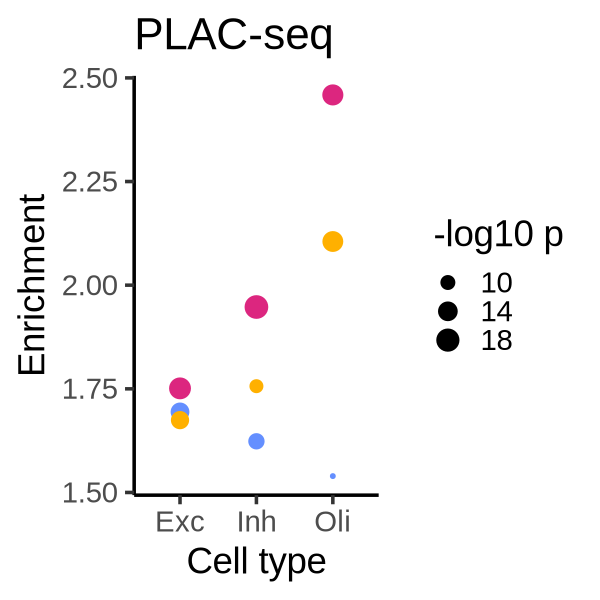

In [17]:
# load data from real_data_analysis/reproducibility_brain.ipynb
overlap_summary_df <- readRDS('results/brain_plac_seq.rds')

overlap_summary_df_small <- overlap_summary_df[overlap_summary_df$cell_type %in% c('Excitatory neurons', 'Inhibitory neurons', 'Oligodendrocytes') &
                          overlap_summary_df$cutoff == 0.2,]
overlap_summary_df_small$cell_type <- factor(overlap_summary_df_small$cell_type,
                                             levels = unique(overlap_summary_df$cell_type),
                                             labels = c('Exc', 'Inh', 'Mic', 'Oli'))
overlap_summary_df_small$log10pval <- -log10(exp(overlap_summary_df_small$log_p_val))

tmp <- ggplot(overlap_summary_df_small) +
geom_point(aes(x = cell_type, y = OR, color = method, size = log10pval)) +
theme_classic(base_size = uniform_bs) +
scale_color_manual(values = colors) +
guides(color="none") +
scale_size_continuous(breaks = c(10, 14, 18)) +
labs(y = 'Enrichment', title = 'PLAC-seq', x = 'Cell type', size = '-log10 p')
g_3_list[['c']] <- tmp + labs(tag = 'c') +
theme(legend.text=element_text(size=15), legend.title=element_text(size=18))

tmp

addWorksheet(wb, "Figure 3c")
writeData(wb, "Figure 3c", overlap_summary_df_small[, c('cell_type','OR','method','log10pval')])

## Panel d

In [18]:
# 
# Extract legend from ggplot object
extractLegend <- function(gg) {
    grobs <- ggplot_gtable(ggplot_build(gg))
    foo <- which(sapply(grobs$grobs, function(x) x$name) == "guide-box")
    grobs$grobs[[foo]]
}

In [19]:
# load data from real_data_analysis/validation_brain_CG_plac_seq.ipynb
long_ct_sum_df <- readRDS('results/brain_reproducibility.rds')

In [20]:
g_count <- ggplot(long_ct_sum_df[!long_ct_sum_df$cell_type %in% c('Astrocytes', 'Microglia'),],
       aes(x = as.factor(p_cutoff), y = repro_counts, group = method, color = method)) +
        geom_line() +
        geom_point(aes(size = -log10(fe_pval))) +
        labs(y = 'Counts', x = 'Cutoff for adjusted p values') +
facet_wrap(~cell_type , scales = 'free') +
scale_color_manual(values = colors) +
labs(size = '-log10 p') +
theme_classic(base_size = 20 )

# Extract wanted legend
wantedLegend <- extractLegend(g_count)

# remove legend
g_count <- g_count + theme(legend.position = "none")
                        
g_or <- ggplot(long_ct_sum_df[!long_ct_sum_df$cell_type %in% c('Astrocytes', 'Microglia') & long_ct_sum_df$repro_counts != 0,],
       aes(x = as.factor(p_cutoff), y = log(fe_or), group = method, color = method)) +
        geom_line() +
        geom_point(aes(size = -log10(fe_pval))) +
        labs(y = 'Enrichment', x = 'Cutoff for adjusted p values') +
facet_wrap(~cell_type , scales = 'free') +
scale_color_manual(values = colors)  +
theme_classic(base_size = 20 ) + theme(legend.position = "none")

In [21]:
g_3_list[['D.1']] <- g_or + labs(tag = 'd')
g_3_list[['D.2']] <- wantedLegend
g_3_list[['D.3']] <- g_count + labs(tag = 'e') 
g_3_list[['D.1']] <- g_3_list[['D.1']] + theme(panel.spacing = unit(1.7, "lines")) +
scale_y_continuous(breaks=c(2,3,4,5), labels = c("2  ", "3  ", "4  ", "5  "))

In [22]:
fig3d_df <- long_ct_sum_df[!long_ct_sum_df$cell_type %in% c('Astrocytes', 'Microglia'), c('p_cutoff', 'repro_counts', 'fe_pval', 'method')]
addWorksheet(wb, "Figure 3d")
writeData(wb, "Figure 3d", fig3d_df)

fig3e_df <- long_ct_sum_df[!long_ct_sum_df$cell_type %in% c('Astrocytes', 'Microglia') & long_ct_sum_df$repro_counts != 0,
                           c('p_cutoff', 'fe_or', 'fe_pval', 'method')]
addWorksheet(wb, "Figure 3e")
writeData(wb, "Figure 3e", fig3e_df)

Warning message:
“Removed 40 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 40 rows containing missing values (`geom_line()`).”


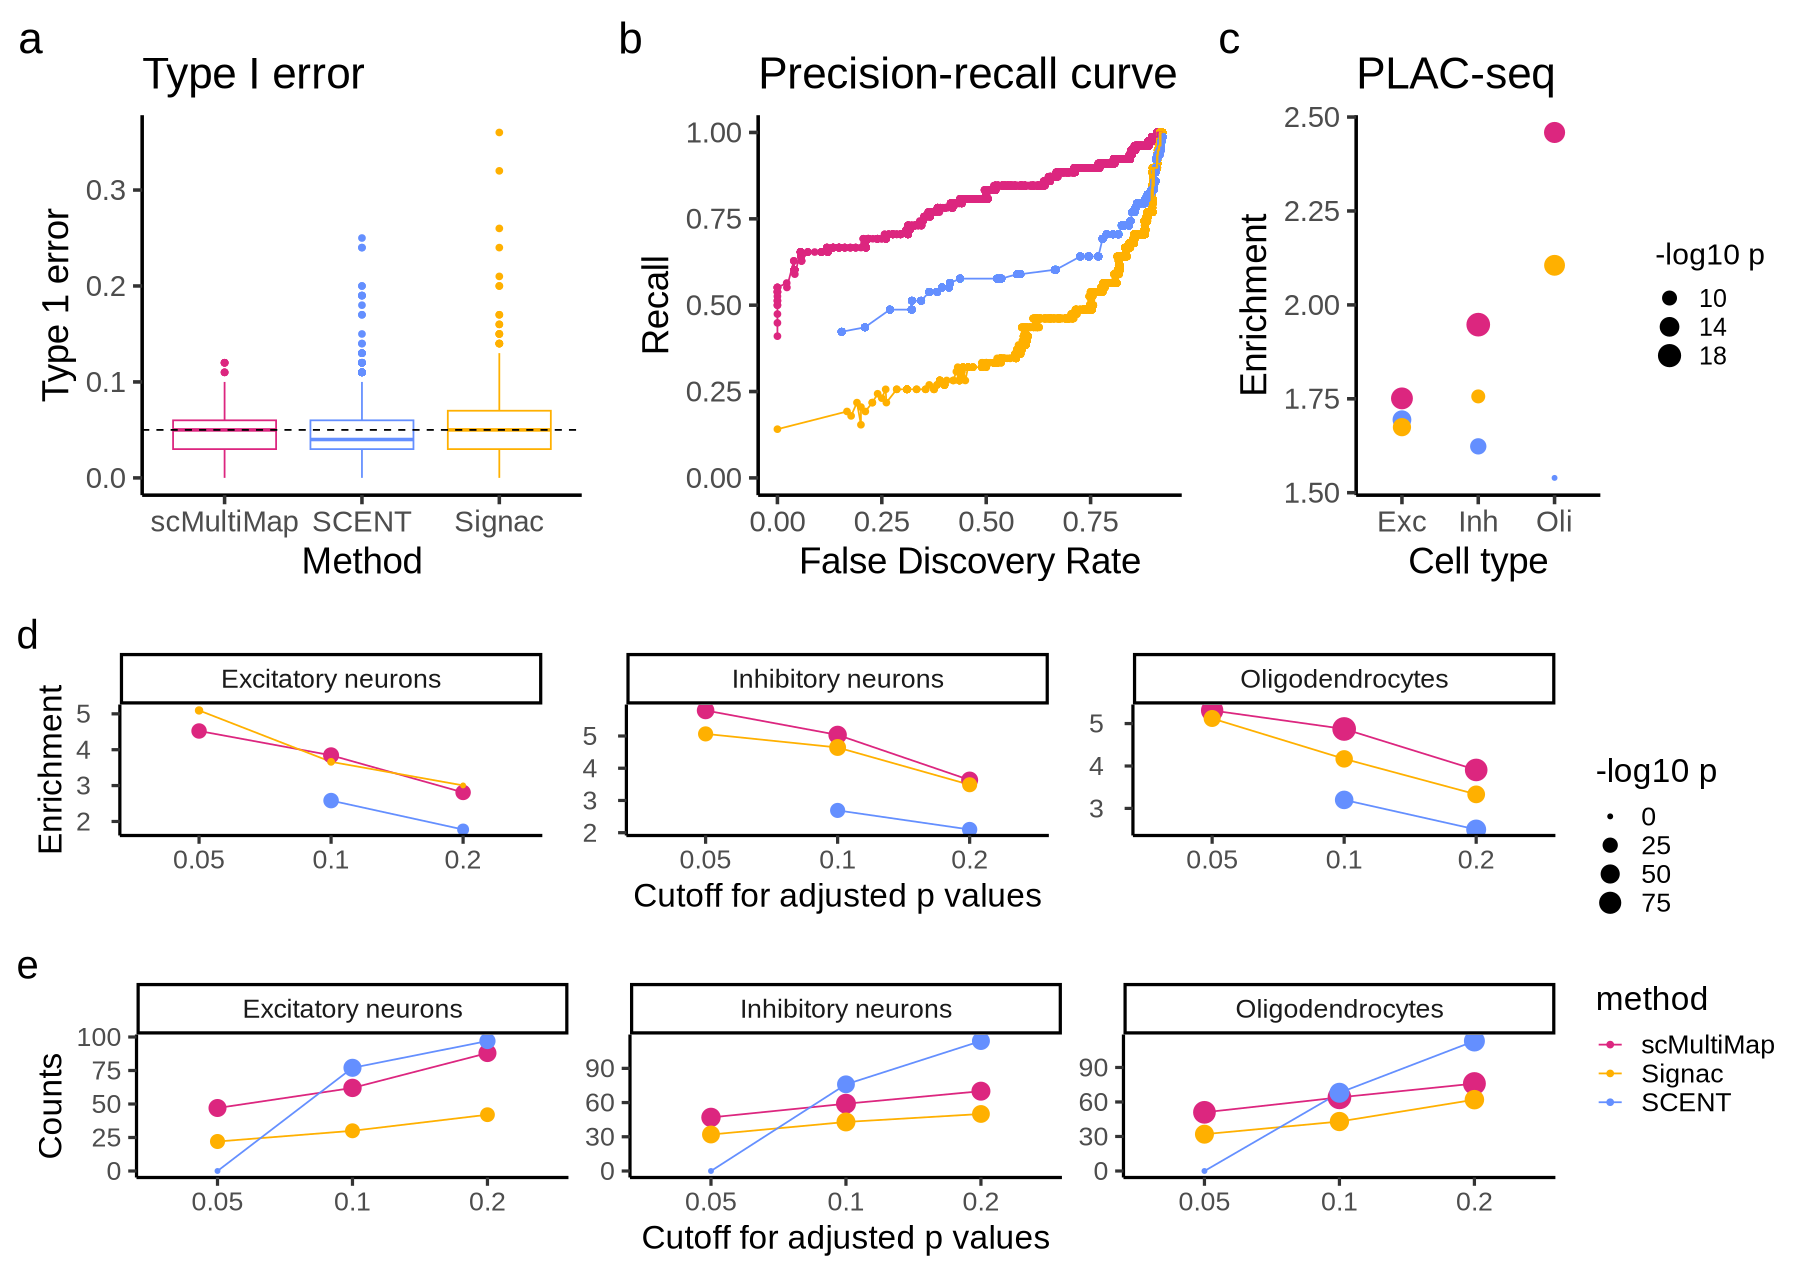

In [23]:
widths_vec <- c(5, 2.5, 2.5, 3.1, 1.9)
heights_vec <- c(5, 2.75, 2.85)#, 5)
options(repr.plot.width = sum(widths_vec), repr.plot.height = sum(heights_vec))

g <- grid.arrange(grobs = g_3_list,
                  widths = widths_vec,
                  heights = heights_vec,
                  layout_matrix = rbind(c(1,2,2,3,3), c(4,4,4,4,5), c(6,6,6,6,5)))
ggsave('figures/Fig_3_brain_a_to_e.pdf', g,
      width = sum(widths_vec), height = sum(heights_vec))

## Panel f-g
See real_data_analysis/trio_brain.ipynb

# Figure 4

In [24]:
g_4_list <- list()
width_vec <- c(7.5, 7.5)
height <- c(5, 5)

## Panel a: LDSC

In [25]:
colors
colors_w_bg <- c(colors, 'grey')
names(colors_w_bg)[4] <- 'background'
colors_w_bg

scMultiMap      SCENT     Signac 
 "#DC267F"  "#648FFF"  "#FFB000"

scMultiMap      SCENT     Signac background 
 "#DC267F"  "#648FFF"  "#FFB000"     "grey"

In [26]:
# generated with real_data_analysis/LDSC
mic_enr <- readRDS('results/heritabiltiy_AD.rds')
mic_enr$label <- ''
mic_enr$label[mic_enr$Enrichment_p < 0.05] <- "*"
mic_enr$label[mic_enr$Enrichment_p < 0.01] <- "**"


addWorksheet(wb, "Figure 4a")
writeData(wb, "Figure 4a", mic_enr)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


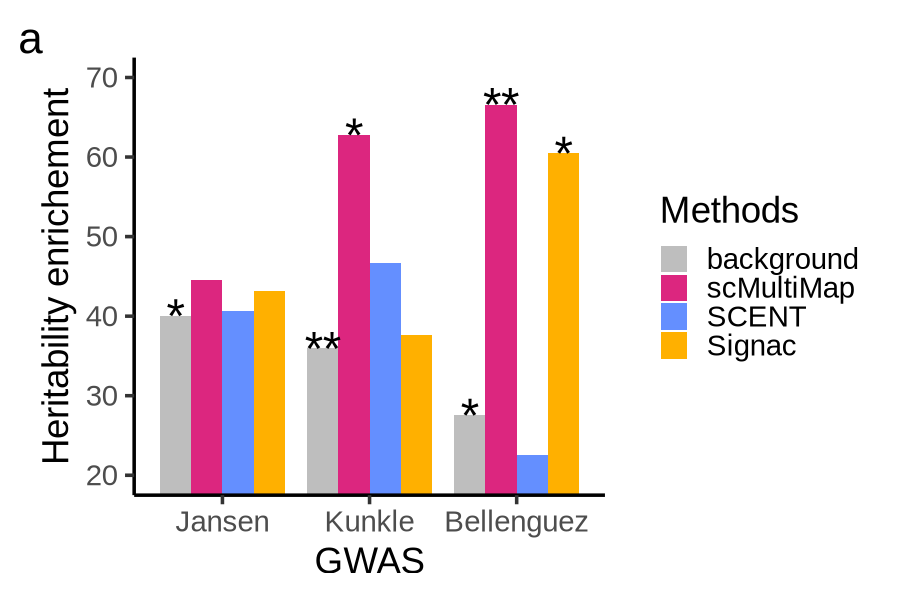

In [27]:
pd <- position_dodge(width = 0.85)

options(repr.plot.width = 7.5, repr.plot.height = 5)
g_4_list[['a']] <- ggplot(mic_enr, aes(x = Sumstat, y = Enrichment, label = label, fill = Methods)) +
geom_bar(aes(fill = Methods),
         position = pd, stat = 'identity', width = 0.85) +
        #position = 'dodge', stat = 'identity', width = 0.8)  + 
geom_text(position = pd, size=10) +
 coord_cartesian(ylim = c(20,70)) +
 scale_fill_manual(values=c('grey', "#F8766D", "#00BA38", "#619CFF"),
                  labels = c('background', 'scMultiMap', 'SCENT', 'Signac')) +
labs(x = 'GWAS', y = 'Heritability enrichement') + #, title = 'Alzheimer\'s disease')
scale_fill_manual(values = colors_w_bg)  +
theme_classic(base_size = uniform_bs ) 

g_4_list[['a']] <- g_4_list[['a']] + labs(tag = 'a')
g_4_list[['a']]

## Panel b-c
See https://changsubiostats.github.io/scMultiMap/articles/disease_control.html

## Panel d-e
See https://changsubiostats.github.io/scMultiMap/articles/GWAS.html

In [29]:
# Save source data
saveWorkbook(wb, "Source Data/main/source_data.xlsx", overwrite = TRUE)